# **Clasificación de Imágenes Utilizando CNN**

## **Conexión de Kaggle con Colab**

In [1]:
import os
import zipfile

#Base de datos
from google.colab import files
files.upload()

! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### **Descarga del Conjunto de Datos**

In [3]:
!kaggle datasets download -d samuelcortinhas/sports-balls-multiclass-image-classification

Dataset URL: https://www.kaggle.com/datasets/samuelcortinhas/sports-balls-multiclass-image-classification
License(s): CC0-1.0
 97% 388M/401M [00:06<00:00, 97.0MB/s]
100% 401M/401M [00:06<00:00, 64.5MB/s]


### **Descomprimir el Conjunto de Datos**

In [4]:
local_zip = '/content/sports-balls-multiclass-image-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

### **Directorios de entrenamiento y pruebas**

In [5]:
import os

In [6]:
train_dir = '/content/train/'
test_dir = '/content/test/'

In [7]:
classes = os.listdir(train_dir)
print("Total Classes: ",len(classes))

Total Classes:  15


In [8]:
train_count = 0
valid_count = 0
test_count = 0
for _class in classes:
    train_count += len(os.listdir(train_dir + '/' + _class))
    test_count += len(os.listdir(test_dir + '/' + _class))

print("Total train images: ",train_count)
print("Total test images: ",test_count)

Total train images:  7328
Total test images:  1841


In [9]:
train_imgs = []
test_imgs = []

for _class in classes:

    for img in os.listdir(train_dir + '/' + _class):
        train_imgs.append(train_dir + '/' + _class + "/" + img)

    for img in os.listdir(test_dir  + '/' + _class):
        test_imgs.append(test_dir + '/' + _class + "/" + img)

class_to_int = {classes[i] : i for i in range(len(classes))}

## **Librerías para la CNN**

In [18]:
import cv2
import torchvision.transforms as T
import numpy as np
import time
from datetime import datetime
from termcolor import colored

import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

from torchvision.utils import make_grid
import torchvision.models as models
import torchvision.transforms as transforms

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

## **Preparación del Conjunto de Datos**

In [16]:
#def get_transform():
#    return T.Compose([T.ToTensor()])


def get_transform():
    return transforms.Compose([
        transforms.ToTensor(),
        # Add this line to resize the images to a fixed size
        transforms.Resize((224, 224))
    ])

class BirdDataset(Dataset):

    def __init__(self, imgs_list, class_to_int, transforms = None):

        super().__init__()
        self.imgs_list = imgs_list
        self.class_to_int = class_to_int
        self.transforms = transforms


    def __getitem__(self, index):

        image_path = self.imgs_list[index]

        #Se lee la imagen
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        #Se obtienen las etiquetas de las clases
        label = image_path.split("/")[-2]
        label = self.class_to_int[label]

        #Applying transforms on image
        if self.transforms:
            image = self.transforms(image)

        return image, label

    def __len__(self):
        return len(self.imgs_list)

In [19]:
train_dataset = BirdDataset(train_imgs, class_to_int, get_transform())
test_dataset = BirdDataset(test_imgs, class_to_int, get_transform())

In [20]:
train_random_sampler = RandomSampler(train_dataset)
test_random_sampler = RandomSampler(test_dataset)

In [21]:
train_data_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 16,
    sampler = train_random_sampler,
    num_workers = 4,
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    batch_size = 16,
    sampler = test_random_sampler,
    num_workers = 4,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## **Visualización de una muestra del conjunto de datos de entrenamiento**

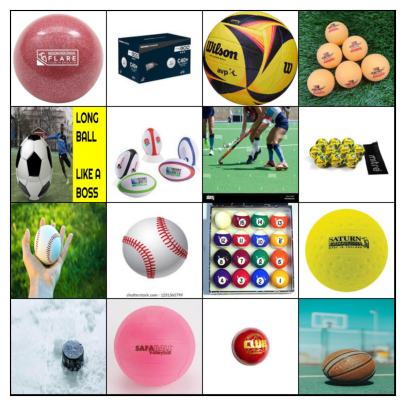

In [22]:
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (5, 5))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

## **Arquitectura VGG16**

In [23]:
### Define model
model = models.vgg16(pretrained = True)

### Modifying last few layers and no of classes
# NOTE: cross_entropy loss takes unnormalized op (logits), then function itself applies softmax and calculates loss, so no need to include softmax here
model.classifier = nn.Sequential(
    nn.Linear(25088, 4096, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(4096, 2048, bias = True),
    nn.ReLU(inplace = True),
    nn.Dropout(0.4),
    nn.Linear(2048, 200)
)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 73.5MB/s]


## **Hiper Parámetros**

In [24]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

train_loss = []
train_accuracy = []

val_loss = []
val_accuracy = []

epochs = 3

In [25]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

## **Entrenamiento**

In [26]:
train_losses = np.zeros(epochs)
val_losses = np.zeros(epochs)
train_accs = np.zeros(epochs)
val_accs = np.zeros(epochs)

In [ ]:
for epoch in range(epochs):

    start = time.time()

    #Train loss and accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []
    _iter = 1

    #Validation Loss and Accuracy
    val_epoch_loss = []
    val_epoch_accuracy = []

    # Entrenamiento
    for images, labels in train_data_loader:

        images = images.to(device)
        labels = labels.to(device)

        #Resetear gradientes
        optimizer.zero_grad()

        #Propagación hacia adelante
        preds = model(images)

        #Cálculo del accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())

        #Calcular la función de costo, propagación hacia atras y optimización
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        #Registro de loss y accuracy
        loss_value = loss.item()
        train_epoch_loss.append(loss_value)
        train_epoch_accuracy.append(acc)

        if _iter % 500 == 0:
            print("> Iteration {} < ".format(_iter))
            print("Iter Loss = {}".format(round(loss_value, 4)))
            print("Iter Accuracy = {} % \n".format(acc))

        _iter += 1

    #Validación
    for images, labels in test_data_loader:

        images = images.to(device)
        labels = labels.to(device)

        #Propagación hacia adelante
        preds = model(images)

        #Cálculo del accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())

        #Cálculo de loss
        loss = criterion(preds, labels)

        #Registro de loss y accuracy
        loss_value = loss.item()
        val_epoch_loss.append(loss_value)
        val_epoch_accuracy.append(acc)


    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)

    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)

    end = time.time()

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)

    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

    #Impresión de métricas de entrenamiento
    print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
    print("Train Loss = {}".format(round(train_epoch_loss, 4)))
    print("Train Accuracy = {} % \n".format(train_epoch_accuracy))
    print("Val Loss = {}".format(round(val_epoch_loss, 4)))
    print("Val Accuracy = {} % \n".format(val_epoch_accuracy))

** Epoch 0 ** - Epoch Time 155
Train Loss = 1.1928
Train Accuracy = 65.18831877729258 % 

Val Loss = 0.7535
Val Accuracy = 78.39439655172414 % 



In [ ]:
duration = end - start

In [ ]:
torch.save(model.state_dict(), "model_sportsball.pth")

In [ ]:
history = {
    'Train_Loss': train_loss,
    'Validation_Loss': val_loss,
    'Train_Accuracy': train_accuracy,
    'Validation_Accuracy': val_accuracy
}

In [ ]:
history

{'Train_Loss': [0.7279446587085724, 0.4031954856145382, 0.2714296939356625],
 'Validation_Loss': [0.5642448373138904,
  0.4486175393469632,
  0.5332816779583692],
 'Train_Accuracy': [76.716, 87.136, 91.498],
 'Validation_Accuracy': [81.59, 85.48, 84.41]}

In [ ]:
result_df = pd.DataFrame(history)
result_df

,Train_Loss,Validation_Loss,Train_Accuracy,Validation_Accuracy
0,0.727945,0.564245,76.716,81.59
1,0.403195,0.448618,87.136,85.48
2,0.271430,0.533282,91.498,84.41


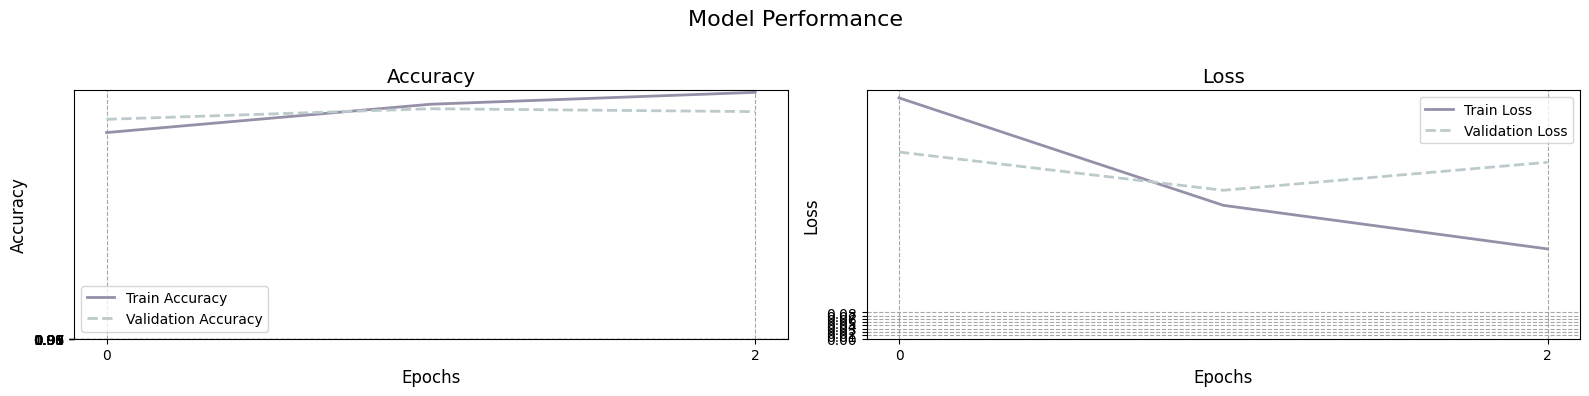

In [ ]:
# Define a range of epochs for the x-axis
x = np.arange(len(result_df))

# Initialize figure and axes for side-by-side plots
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
fig.suptitle('Model Performance', fontsize=16)

# ax[0] ---> Accuracy
ax[0].plot(x, result_df.Train_Accuracy, label='Train Accuracy', linewidth=2, color='#9590a8')
ax[0].plot(x, result_df.Validation_Accuracy, label='Validation Accuracy', linewidth=2, linestyle='--', color='#bbcbcb')
ax[0].set_title('Accuracy', fontsize=14)
ax[0].set_yticks(np.arange(0.95, 1.01, 0.01))
ax[0].set_xticks(np.arange(0, len(result_df), 2))
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)
ax[0].legend()
ax[0].grid(True, linestyle='--', color='gray', alpha=0.7)
ax[0].set_facecolor('white')

# ax[1] ---> Loss
ax[1].plot(x, result_df.Train_Loss, label='Train Loss', linewidth=2, color='#9590a8')
ax[1].plot(x, result_df.Validation_Loss, label='Validation Loss', linewidth=2, linestyle='--', color='#bbcbcb')
ax[1].set_title('Loss', fontsize=14)
ax[1].set_xticks(np.arange(0, len(result_df), 2))
ax[1].set_yticks(np.arange(0, 0.085, 0.01))
ax[1].set_xlabel('Epochs', fontsize=12)
ax[1].set_ylabel('Loss', fontsize=12)
ax[1].legend()
ax[1].grid(True, linestyle='--', color='gray', alpha=0.7)
ax[1].set_facecolor('white')

# Adjust layout to make room for the super title
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plots
plt.show()

## **Evaluation**

In [ ]:
# Evaluate the model on the test set without calculating gradients
with torch.no_grad():
    model.eval()
    start_time = datetime.now()
    test_loss = []
    total_correct = 0
    total_samples = 0

    for images, labels in test_data_loader:
        # Move images and labels to the GPU
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass to get predictions
        predictions = model(images)
        loss = criterion(predictions, labels)

        # Append loss to test_loss list
        test_loss.append(loss.item())

        # Calculate number of correct predictions
        _, predicted_classes = torch.max(predictions, 1)
        total_correct += (predicted_classes == labels).sum().item()
        total_samples += labels.size(0)

    # Compute average test loss and accuracy
    avg_test_loss = np.mean(test_loss)
    test_accuracy = total_correct / total_samples
    elapsed_time = datetime.now() - start_time

    # Print the results with custom formatting
    print(colored(f'Loss: {avg_test_loss:.4f}\nAccuracy: {test_accuracy:.4f}\nDuration: {elapsed_time}', 'cyan'))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loss: 0.5297
Accuracy: 0.8440
Duration: 0:00:07.006170


In [ ]:
model_on_device = model.to(device)

true_labels_list = []
predicted_labels_list = []

for batch_images, batch_labels in test_data_loader:
    batch_images = batch_images.to(device)
    batch_labels = batch_labels.numpy()
    output_predictions = model_on_device(batch_images)
    _, predicted_batch_labels = torch.max(output_predictions.data, 1)
    predicted_batch_labels = predicted_batch_labels.detach().cpu().numpy()
    true_labels_list = np.append(true_labels_list, batch_labels)
    predicted_labels_list = np.append(predicted_labels_list, predicted_batch_labels)

In [ ]:
model = model.to(device)
y_true = []
y_pred = []
for images, labels in test_data_loader:
    images = images.to(device)
    labels = labels.numpy()
    outputs = model(images)
    _, pred = torch.max(outputs.data, 1)
    pred = pred.detach().cpu().numpy()
    y_true = np.append(y_true, labels)
    y_pred = np.append(y_pred, pred)

In [ ]:
class_names = class_to_int.keys()

In [ ]:
print(colored("\nReporte de Clasificación:"))
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)


Reporte de Clasificación:
              precision    recall  f1-score   support

       horse       0.91      0.87      0.89      1000
        deer       0.94      0.70      0.81      1000
  automobile       0.82      0.98      0.90      1000
        ship       0.97      0.83      0.89      1000
       truck       0.98      0.80      0.88      1000
        bird       0.77      0.85      0.81      1000
         cat       0.69      0.81      0.74      1000
         dog       0.85      0.74      0.79      1000
    airplane       0.74      0.96      0.83      1000
        frog       0.90      0.90      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.86      0.84      0.84     10000
weighted avg       0.86      0.84      0.84     10000



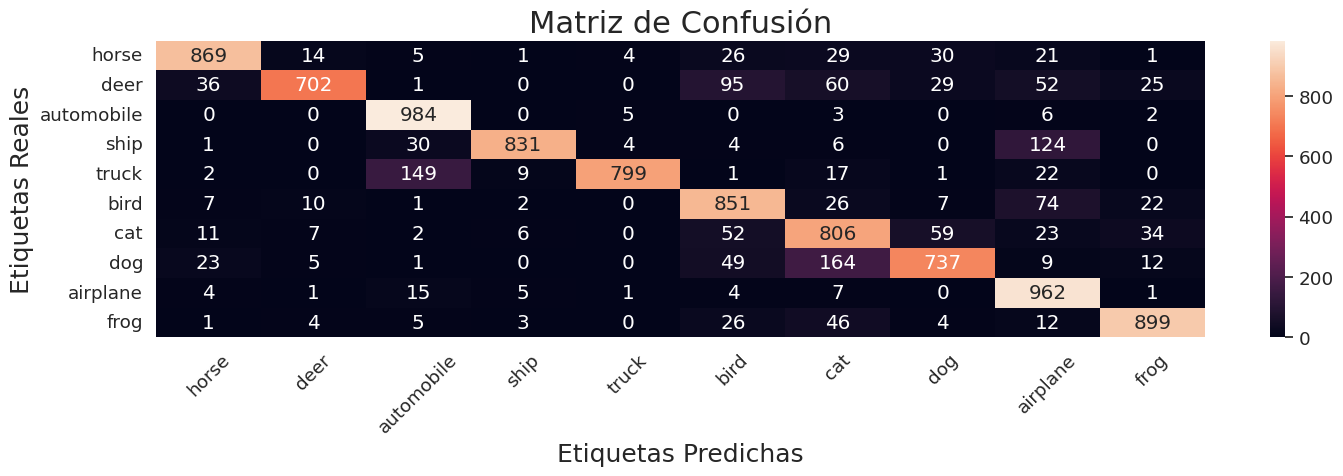

In [ ]:
def plot_custom_confusion_matrix(y_true, y_pred):
    """Plot the confusion matrix for the classification results using a custom color palette."""

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(15, 5))
    sns.set(font_scale=1.2)
    ax = sns.heatmap(cm, annot=True, fmt='g', cbar=True)
    ax.set_xlabel('Etiquetas Predichas', fontsize=18)
    ax.set_ylabel('Etiquetas Reales', fontsize=18)
    ax.set_title('Matriz de Confusión', fontsize=22)
    ax.xaxis.set_ticklabels(class_names, rotation=45)
    ax.yaxis.set_ticklabels(class_names, rotation=0)
    plt.tight_layout()
    plt.show()

plot_custom_confusion_matrix(y_true, y_pred)